<a href="https://colab.research.google.com/github/punchnami/AI-Powered-Research-Query-Chatbot/blob/main/predictive_model_arimax_rollout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [44]:
import glob, matplotlib.pyplot as plt, numpy as np, os, pandas as pd, seaborn as sns, warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

# Data Cleaning & Merging

## Search

In [45]:
search_file_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/1. BGCR; SOFR/Search.xlsx'
df = pd.read_excel(search_file_path)
df_cleaned = df.dropna(axis=1, how='all')
df_cleaned = df_cleaned.drop(columns=['Footnote ID'])
df_cleaned = df_cleaned[df_cleaned['Rate Type'] == 'BGCR']
df_BGCR = df_cleaned.copy()
df_BGCR = df_BGCR.rename(columns={'Effective Date': 'Date'})

## Daily Treasury Rates Sheet

In [46]:
d_treas_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/2 3. Treasury Yield; Yield Spread; Federal'
files_to_concatenate = [
    'daily-treasury-rates_2018.csv',
    'daily-treasury-rates_2019.csv',
    'daily-treasury-rates_2020.csv',
    'daily-treasury-rates_2021.csv',
    'daily-treasury-rates_2022.csv',
    'daily-treasury-rates_2023.csv',
    'daily-treasury-rates_2024.csv'
]
df_list = []
for file in files_to_concatenate:
    file_path = os.path.join(d_treas_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)
merged_df = pd.concat(df_list, ignore_index=True)
merged_df = merged_df.dropna(axis=1, how='all')
if 'Footnote ID' in merged_df.columns:
    merged_df = merged_df.drop(columns=['Footnote ID'])
merged_daily_treasury_rates = merged_df.copy()

In [47]:
merged_daily_treasury_rates

,Date,4 WEEKS BANK DISCOUNT,4 WEEKS COUPON EQUIVALENT,8 WEEKS BANK DISCOUNT,8 WEEKS COUPON EQUIVALENT,13 WEEKS BANK DISCOUNT,13 WEEKS COUPON EQUIVALENT,26 WEEKS BANK DISCOUNT,26 WEEKS COUPON EQUIVALENT,52 WEEKS BANK DISCOUNT,52 WEEKS COUPON EQUIVALENT,17 WEEKS BANK DISCOUNT,17 WEEKS COUPON EQUIVALENT
0,12/31/2018,2.40,2.44,2.41,2.45,2.40,2.45,2.50,2.57,2.54,2.63,NaN,NaN
1,12/28/2018,2.35,2.39,2.43,2.47,2.35,2.40,2.42,2.48,2.51,2.59,NaN,NaN
2,12/27/2018,2.39,2.43,2.42,2.46,2.36,2.41,2.43,2.49,2.50,2.58,NaN,NaN
3,12/26/2018,2.37,2.41,2.38,2.42,2.39,2.44,2.47,2.54,2.53,2.61,NaN,NaN
4,12/24/2018,2.38,2.42,2.38,2.42,2.41,2.46,2.46,2.53,2.53,2.61,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619,01/08/2024,5.28,5.39,5.28,5.41,5.25,5.41,5.04,5.26,4.59,4.83,5.19,5.37
1620,01/05/2024,5.28,5.39,5.27,5.40,5.24,5.40,5.05,5.27,4.61,4.85,5.20,5.38
1621,01/04/2024,5.29,5.40,5.28,5.41,5.24,5.40,5.06,5.28,4.61,4.85,5.21,5.39
1622,01/03/2024,5.27,5.38,5.28,5.41,5.24,5.40,5.06,5.28,4.58,4.82,5.21,5.39


## Daily Treasury Rates LT Sheet

In [48]:
files_to_concatenate = [
    'daily-treasury-rates_LT_2018.csv',
    'daily-treasury-rates_LT_2019.csv',
    'daily-treasury-rates_LT_2020.csv',
    'daily-treasury-rates_LT_2021.csv',
    'daily-treasury-rates_LT_2022.csv',
    'daily-treasury-rates_LT_2023.csv',
    'daily-treasury-rates_LT_2024.csv'
]
df_list = []
for file in files_to_concatenate:
    file_path = os.path.join(d_treas_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)
merged_df = pd.concat(df_list, ignore_index=True)
merged_df = merged_df.dropna(axis=1, how='all')
if 'Footnote ID' in merged_df.columns:
    merged_df = merged_df.drop(columns=['Footnote ID'])
merged_daily_treasury_LT_rates = merged_df.copy()

df_merged = pd.merge(merged_daily_treasury_rates, merged_daily_treasury_LT_rates, on='Date', how='inner')

In [49]:
df_merged

,Date,4 WEEKS BANK DISCOUNT,4 WEEKS COUPON EQUIVALENT,8 WEEKS BANK DISCOUNT,8 WEEKS COUPON EQUIVALENT,13 WEEKS BANK DISCOUNT,13 WEEKS COUPON EQUIVALENT,26 WEEKS BANK DISCOUNT,26 WEEKS COUPON EQUIVALENT,52 WEEKS BANK DISCOUNT,52 WEEKS COUPON EQUIVALENT,17 WEEKS BANK DISCOUNT,17 WEEKS COUPON EQUIVALENT,LT COMPOSITE (>10 Yrs),TREASURY 20-Yr CMT
0,12/31/2018,2.40,2.44,2.41,2.45,2.40,2.45,2.50,2.57,2.54,2.63,NaN,NaN,2.95,2.87
1,12/28/2018,2.35,2.39,2.43,2.47,2.35,2.40,2.42,2.48,2.51,2.59,NaN,NaN,2.97,2.89
2,12/27/2018,2.39,2.43,2.42,2.46,2.36,2.41,2.43,2.49,2.50,2.58,NaN,NaN,2.99,2.92
3,12/26/2018,2.37,2.41,2.38,2.42,2.39,2.44,2.47,2.54,2.53,2.61,NaN,NaN,3.01,2.94
4,12/24/2018,2.38,2.42,2.38,2.42,2.41,2.46,2.46,2.53,2.53,2.61,NaN,NaN,2.94,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619,01/08/2024,5.28,5.39,5.28,5.41,5.25,5.41,5.04,5.26,4.59,4.83,5.19,5.37,4.28,4.33
1620,01/05/2024,5.28,5.39,5.27,5.40,5.24,5.40,5.05,5.27,4.61,4.85,5.20,5.38,4.32,4.37
1621,01/04/2024,5.29,5.40,5.28,5.41,5.24,5.40,5.06,5.28,4.61,4.85,5.21,5.39,4.25,4.30
1622,01/03/2024,5.27,5.38,5.28,5.41,5.24,5.40,5.06,5.28,4.58,4.82,5.21,5.39,4.16,4.21


## Feature Additions

In [50]:
# Calculate short-term yield spreads
df_merged['Yield Spread (4W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (13W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['13 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (26W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['26 WEEKS COUPON EQUIVALENT']

# Calculate long-term yield spreads
df_merged['Yield Spread (10Y - 4W)'] = df_merged['LT COMPOSITE (>10 Yrs)'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (20Y - 4W)'] = df_merged['TREASURY 20-Yr CMT'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (10Y - 52W)'] = df_merged['LT COMPOSITE (>10 Yrs)'] - df_merged['52 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (20Y - 52W)'] = df_merged['TREASURY 20-Yr CMT'] - df_merged['52 WEEKS COUPON EQUIVALENT']

## Columns to Keep

In [51]:
columns_to_keep = [
    'Date',
    '4 WEEKS COUPON EQUIVALENT',
    '13 WEEKS COUPON EQUIVALENT',
    '26 WEEKS COUPON EQUIVALENT',
    '52 WEEKS COUPON EQUIVALENT',
    'LT COMPOSITE (>10 Yrs)',
    'TREASURY 20-Yr CMT',
    'Yield Spread (4W - 52W)',
    'Yield Spread (13W - 52W)',
    'Yield Spread (26W - 52W)',
    'Yield Spread (10Y - 4W)',
    'Yield Spread (20Y - 4W)',
    'Yield Spread (10Y - 52W)',
    'Yield Spread (20Y - 52W)'
]
df_relevant = df_merged[columns_to_keep]

df_merged = pd.merge(df_BGCR, df_relevant, on='Date', how='inner')
df_merged['Date'] = pd.to_datetime(df_merged['Date'])

In [52]:
df_merged

,Date,Rate Type,Rate (%),1st Percentile (%),25th Percentile (%),75th Percentile (%),99th Percentile (%),Volume ($Billions),4 WEEKS COUPON EQUIVALENT,13 WEEKS COUPON EQUIVALENT,...,52 WEEKS COUPON EQUIVALENT,LT COMPOSITE (>10 Yrs),TREASURY 20-Yr CMT,Yield Spread (4W - 52W),Yield Spread (13W - 52W),Yield Spread (26W - 52W),Yield Spread (10Y - 4W),Yield Spread (20Y - 4W),Yield Spread (10Y - 52W),Yield Spread (20Y - 52W)
0,2024-06-27,BGCR,5.32,5.25,5.32,5.33,5.39,732,5.37,5.37,...,5.12,4.50,4.53,-0.25,-0.25,-0.21,-0.87,-0.84,-0.62,-0.59
1,2024-06-26,BGCR,5.33,5.26,5.33,5.34,5.44,740,5.33,5.38,...,5.14,4.52,4.55,-0.19,-0.24,-0.21,-0.81,-0.78,-0.62,-0.59
2,2024-06-25,BGCR,5.32,5.27,5.32,5.33,5.42,751,5.32,5.37,...,5.11,4.43,4.46,-0.21,-0.26,-0.24,-0.89,-0.86,-0.68,-0.65
3,2024-06-24,BGCR,5.30,5.25,5.30,5.31,5.37,755,5.31,5.38,...,5.11,4.45,4.48,-0.20,-0.27,-0.24,-0.86,-0.83,-0.66,-0.63
4,2024-06-21,BGCR,5.30,5.25,5.30,5.31,5.37,760,5.31,5.37,...,5.11,4.46,4.49,-0.20,-0.26,-0.24,-0.85,-0.82,-0.65,-0.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555,2018-04-06,BGCR,1.70,1.60,1.70,1.70,1.83,352,1.67,1.73,...,2.06,2.94,2.89,0.39,0.33,0.16,1.27,1.22,0.88,0.83
1556,2018-04-05,BGCR,1.70,1.60,1.70,1.70,1.85,349,1.66,1.72,...,2.07,3.01,2.95,0.41,0.35,0.15,1.35,1.29,0.94,0.88
1557,2018-04-04,BGCR,1.70,1.57,1.70,1.70,1.81,348,1.68,1.71,...,2.07,2.97,2.91,0.39,0.36,0.17,1.29,1.23,0.90,0.84
1558,2018-04-03,BGCR,1.81,1.50,1.80,1.82,1.97,344,1.70,1.75,...,2.09,2.96,2.90,0.39,0.34,0.17,1.26,1.20,0.87,0.81


## Add SPX

In [53]:
spx_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalData_1719610851813_SPX.csv'
df = pd.read_csv(spx_path)
df = df.drop(columns=['Open', 'High', 'Low'])
df = df.rename(columns={'Close/Last': 'SPX'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged2 = pd.merge(df_merged, df, on='Date', how='inner')

## Add NASDAQ

In [54]:
nasdaq_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalData_1719611009685_COMP.csv'
df = pd.read_csv(nasdaq_path)
df = df.drop(columns=['Open', 'High', 'Low'])
df = df.rename(columns={'Close/Last': 'NASDAQ'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged3 = pd.merge(df_merged2, df, on='Date', how='inner')

## Add DJIA

In [55]:
djia_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalPrices_DJIA.csv'
df = pd.read_csv(djia_path)
df = df.drop(columns=[' Open', ' High', ' Low'], axis=1)
df = df.rename(columns={' Close': 'DJIA'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged4 = pd.merge(df_merged3, df, on='Date', how='inner')

<ipython-input-55-6b946d107c28>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


## Add ForEx

In [56]:
forex_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/7. FX/FRB_H10.csv'
df = pd.read_csv(forex_path)
df = df.iloc[5:]
df.rename(columns={'Series Description': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

df_merged5 = pd.merge(df_merged4, df, on='Date', how='inner')

In [57]:
df_merged5

,Date,Rate Type,Rate (%),1st Percentile (%),25th Percentile (%),75th Percentile (%),99th Percentile (%),Volume ($Billions),4 WEEKS COUPON EQUIVALENT,13 WEEKS COUPON EQUIVALENT,...,Yield Spread (20Y - 4W),Yield Spread (10Y - 52W),Yield Spread (20Y - 52W),SPX,NASDAQ,DJIA,SPOT EXCHANGE RATE - EURO AREA,"UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)","CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.","JAPAN -- SPOT EXCHANGE RATE, YEN/US$"
0,2024-06-21,BGCR,5.30,5.25,5.30,5.31,5.37,760,5.31,5.37,...,-0.82,-0.65,-0.62,5464.62,17689.36,39150.33,1.0694,1.2645,7.2609,159.4500
1,2024-06-20,BGCR,5.31,5.25,5.31,5.31,5.36,767,5.31,5.38,...,-0.82,-0.65,-0.62,5473.17,17721.59,39134.76,1.0708,1.2671,7.2604,158.7700
2,2024-06-18,BGCR,5.32,5.25,5.32,5.32,5.41,763,5.29,5.38,...,-0.82,-0.66,-0.62,5487.03,17862.23,38834.86,1.0739,1.2699,7.2543,157.8100
3,2024-06-17,BGCR,5.32,5.26,5.31,5.32,5.42,772,5.34,5.39,...,-0.82,-0.63,-0.59,5473.23,17857.02,38778.10,1.0723,1.2689,7.2561,157.8000
4,2024-06-14,BGCR,5.30,5.25,5.30,5.31,5.37,785,5.35,5.39,...,-0.89,-0.64,-0.60,5431.60,17688.88,38589.16,1.0699,1.2685,7.2557,157.2800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,2018-04-06,BGCR,1.70,1.60,1.70,1.70,1.83,352,1.67,1.73,...,1.22,0.88,0.83,2604.47,6915.11,23932.76,1.2274,1.4088,6.3045,107.0300
1552,2018-04-05,BGCR,1.70,1.60,1.70,1.70,1.85,349,1.66,1.72,...,1.29,0.94,0.88,2662.84,7076.55,24505.22,1.2230,1.3991,6.3045,107.4800
1553,2018-04-04,BGCR,1.70,1.57,1.70,1.70,1.81,348,1.68,1.71,...,1.23,0.90,0.84,2644.69,7042.11,24264.30,1.2292,1.4076,6.3045,106.5600
1554,2018-04-03,BGCR,1.81,1.50,1.80,1.82,1.97,344,1.70,1.75,...,1.20,0.87,0.81,2614.45,6941.28,24033.36,1.2261,1.4068,6.2881,106.4500


In [58]:
df_merged5.replace('ND', np.nan, inplace=True)
df_merged5.dropna(inplace=True)

df_merged5 = df_merged5.drop(columns=['Rate Type', '1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)'])
df_merged5.set_index('Date', inplace= True)

cols = ['SPOT EXCHANGE RATE - EURO AREA ', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']
df_merged5[cols] = df_merged5[cols].astype(float)

df_monthly = df_merged5.resample('M').median()

df_monthly

,Rate (%),Volume ($Billions),4 WEEKS COUPON EQUIVALENT,13 WEEKS COUPON EQUIVALENT,26 WEEKS COUPON EQUIVALENT,52 WEEKS COUPON EQUIVALENT,LT COMPOSITE (>10 Yrs),TREASURY 20-Yr CMT,Yield Spread (4W - 52W),Yield Spread (13W - 52W),...,Yield Spread (20Y - 4W),Yield Spread (10Y - 52W),Yield Spread (20Y - 52W),SPX,NASDAQ,DJIA,SPOT EXCHANGE RATE - EURO AREA,"UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)","CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.","JAPAN -- SPOT EXCHANGE RATE, YEN/US$"
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-30,1.70,344.0,1.660,1.790,1.990,2.110,2.980,2.920,0.480,0.350,...,1.290,0.870,0.820,2656.870,7094.300,24322.340,1.22880,1.40760,6.29450,107.300
2018-05-31,1.70,358.0,1.685,1.905,2.075,2.265,3.085,3.040,0.585,0.380,...,1.365,0.825,0.785,2716.550,7388.255,24710.195,1.18250,1.34970,6.36750,109.525
2018-06-30,1.83,376.0,1.810,1.940,2.120,2.320,3.020,2.980,0.510,0.380,...,1.160,0.690,0.660,2762.590,7659.930,24799.980,1.16750,1.32830,6.43790,110.020
2018-07-31,1.87,388.0,1.890,1.990,2.160,2.390,2.940,2.910,0.480,0.370,...,1.030,0.600,0.570,2801.830,7805.720,25058.120,1.16920,1.31500,6.70180,111.270
2018-08-31,1.90,413.0,1.940,2.070,2.230,2.430,2.990,2.960,0.500,0.360,...,1.000,0.540,0.500,2856.980,7870.890,25628.910,1.15950,1.28800,6.84000,110.980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29,5.30,681.0,5.390,5.390,5.325,4.970,4.500,4.520,-0.425,-0.425,...,-0.880,-0.450,-0.425,5003.095,15826.430,38674.525,1.07845,1.26285,7.19285,150.045
2024-03-31,5.30,684.5,5.380,5.380,5.320,5.005,4.445,4.465,-0.365,-0.370,...,-0.905,-0.540,-0.520,5161.335,16236.575,39024.405,1.08615,1.27130,7.19790,150.170
2024-04-30,5.31,700.5,5.380,5.390,5.370,5.170,4.795,4.820,-0.210,-0.225,...,-0.560,-0.385,-0.350,5108.065,15955.490,38422.585,1.07060,1.25040,7.23780,154.400


## Add CPI

In [59]:
cpi_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Jan': [247.867, 251.712, 257.971, 261.582, 281.148, 299.170, 308.417],
    'Feb': [248.991, 252.776, 258.678, 263.014, 283.716, 300.840, 310.326],
    'Mar': [249.554, 254.202, 258.115, 264.877, 287.504, 301.836, 312.332],
    'Apr': [250.546, 255.548, 256.389, 267.054, 289.109, 303.363, 313.548],
    'May': [251.588, 256.092, 256.934, 269.195, 292.296, 304.127, 314.069],
    'Jun': [251.988, 256.143, 257.797, 271.696, 296.311, 305.109, 314.069],
    'Jul': [252.006, 256.571, 259.101, 273.003, 296.276, 305.691, None],
    'Aug': [252.146, 256.558, 259.918, 273.567, 296.171, 307.026, None],
    'Sep': [252.439, 256.759, 260.280, 274.310, 296.908, 307.789, None],
    'Oct': [252.885, 257.346, 260.388, 276.589, 298.012, 307.671, None],
    'Nov': [252.038, 257.346, 260.229, 277.948, 297.711, 307.051, None],
    'Dec': [251.233, 257.208, 260.474, 278.802, 296.797, 306.746, None]
}


cpi_df = pd.DataFrame(cpi_data)
cpi_long_df = pd.melt(cpi_df, id_vars=['Year'], var_name='Month', value_name='CPI')
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
cpi_long_df['Month'] = cpi_long_df['Month'].map(month_mapping)
cpi_long_df['Day'] = 1
cpi_long_df['Date'] = pd.to_datetime(cpi_long_df[['Year', 'Month', 'Day']])
cpi_long_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)
cpi_long_df.set_index('Date', inplace=True)

cpi_long_df = cpi_long_df.resample('M').mean()

df_merged6 = pd.merge(df_monthly, cpi_long_df, on='Date', how='left')

In [60]:
df_merged6

,Rate (%),Volume ($Billions),4 WEEKS COUPON EQUIVALENT,13 WEEKS COUPON EQUIVALENT,26 WEEKS COUPON EQUIVALENT,52 WEEKS COUPON EQUIVALENT,LT COMPOSITE (>10 Yrs),TREASURY 20-Yr CMT,Yield Spread (4W - 52W),Yield Spread (13W - 52W),...,Yield Spread (10Y - 52W),Yield Spread (20Y - 52W),SPX,NASDAQ,DJIA,SPOT EXCHANGE RATE - EURO AREA,"UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)","CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.","JAPAN -- SPOT EXCHANGE RATE, YEN/US$",CPI
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-30,1.70,344.0,1.660,1.790,1.990,2.110,2.980,2.920,0.480,0.350,...,0.870,0.820,2656.870,7094.300,24322.340,1.22880,1.40760,6.29450,107.300,250.546
2018-05-31,1.70,358.0,1.685,1.905,2.075,2.265,3.085,3.040,0.585,0.380,...,0.825,0.785,2716.550,7388.255,24710.195,1.18250,1.34970,6.36750,109.525,251.588
2018-06-30,1.83,376.0,1.810,1.940,2.120,2.320,3.020,2.980,0.510,0.380,...,0.690,0.660,2762.590,7659.930,24799.980,1.16750,1.32830,6.43790,110.020,251.988
2018-07-31,1.87,388.0,1.890,1.990,2.160,2.390,2.940,2.910,0.480,0.370,...,0.600,0.570,2801.830,7805.720,25058.120,1.16920,1.31500,6.70180,111.270,252.006
2018-08-31,1.90,413.0,1.940,2.070,2.230,2.430,2.990,2.960,0.500,0.360,...,0.540,0.500,2856.980,7870.890,25628.910,1.15950,1.28800,6.84000,110.980,252.146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29,5.30,681.0,5.390,5.390,5.325,4.970,4.500,4.520,-0.425,-0.425,...,-0.450,-0.425,5003.095,15826.430,38674.525,1.07845,1.26285,7.19285,150.045,310.326
2024-03-31,5.30,684.5,5.380,5.380,5.320,5.005,4.445,4.465,-0.365,-0.370,...,-0.540,-0.520,5161.335,16236.575,39024.405,1.08615,1.27130,7.19790,150.170,312.332
2024-04-30,5.31,700.5,5.380,5.390,5.370,5.170,4.795,4.820,-0.210,-0.225,...,-0.385,-0.350,5108.065,15955.490,38422.585,1.07060,1.25040,7.23780,154.400,313.548


## Add PPI

In [61]:
ppi_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Jan': [114.8, 117, 119.3, 121.2, 133.576, 141.286, 142.683],
    'Feb': [115.1, 117.2, 118.6, 122, 134.821, 141.237, 143.509],
    'Mar': [115.3, 117.6, 118, 122.8, 137.041, 140.738, 143.410],
    'Apr': [115.5, 118.2, 116.6, 124.1, 137.805, 140.977, 144.119],
    'May': [115.9, 118.3, 117.2, 125.3, 139.026, 140.664, 144.079],
    'Jun': [116.3, 118.2, 117.5, 126.2, 140.238, 140.672, 144.402],
    'Jul': [116.4, 118.5, 118.2, 127.504, 139.837, 141.461, None],
    'Aug': [116.5, 118.6, 118.4, 128.574, 139.721, 142.353, None],
    'Sep': [116.7, 118.3, 118.7, 129.188, 140.137, 142.658, None],
    'Oct': [117.5, 118.8, 119.4, 130.061, 140.666, 142.191, None],
    'Nov': [117.4, 118.6, 119.5, 131.455, 141.18, 142.267, None],
    'Dec': [117.4, 119, 120, 132.224, 140.696, 142.17, None]
}

# Converting PPI data to DataFrame
ppi_df = pd.DataFrame(ppi_data)

# Melting the PPI DataFrame to long format
ppi_long_df = pd.melt(ppi_df, id_vars=['Year'], var_name='Month', value_name='PPI')

# Mapping month names to numbers
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
ppi_long_df['Month'] = ppi_long_df['Month'].map(month_mapping)

# Creating a 'Day' column with value 1 for each row
ppi_long_df['Day'] = 1

# Creating a date column in the PPI DataFrame
ppi_long_df['Date'] = pd.to_datetime(ppi_long_df[['Year', 'Month', 'Day']])

# Dropping unnecessary columns
ppi_long_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

# Setting the Date as the index
ppi_long_df.set_index('Date', inplace=True)

# Reindexing to fill in missing dates with forward fill for the last known PPI value of each month
ppi_long_df = ppi_long_df.resample('M').mean()

df_merged7 = pd.merge(df_merged6, ppi_long_df, on='Date', how='inner')

In [62]:
df_merged7

,Rate (%),Volume ($Billions),4 WEEKS COUPON EQUIVALENT,13 WEEKS COUPON EQUIVALENT,26 WEEKS COUPON EQUIVALENT,52 WEEKS COUPON EQUIVALENT,LT COMPOSITE (>10 Yrs),TREASURY 20-Yr CMT,Yield Spread (4W - 52W),Yield Spread (13W - 52W),...,Yield Spread (20Y - 52W),SPX,NASDAQ,DJIA,SPOT EXCHANGE RATE - EURO AREA,"UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)","CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.","JAPAN -- SPOT EXCHANGE RATE, YEN/US$",CPI,PPI
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-30,1.70,344.0,1.660,1.790,1.990,2.110,2.980,2.920,0.480,0.350,...,0.820,2656.870,7094.300,24322.340,1.22880,1.40760,6.29450,107.300,250.546,115.500
2018-05-31,1.70,358.0,1.685,1.905,2.075,2.265,3.085,3.040,0.585,0.380,...,0.785,2716.550,7388.255,24710.195,1.18250,1.34970,6.36750,109.525,251.588,115.900
2018-06-30,1.83,376.0,1.810,1.940,2.120,2.320,3.020,2.980,0.510,0.380,...,0.660,2762.590,7659.930,24799.980,1.16750,1.32830,6.43790,110.020,251.988,116.300
2018-07-31,1.87,388.0,1.890,1.990,2.160,2.390,2.940,2.910,0.480,0.370,...,0.570,2801.830,7805.720,25058.120,1.16920,1.31500,6.70180,111.270,252.006,116.400
2018-08-31,1.90,413.0,1.940,2.070,2.230,2.430,2.990,2.960,0.500,0.360,...,0.500,2856.980,7870.890,25628.910,1.15950,1.28800,6.84000,110.980,252.146,116.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29,5.30,681.0,5.390,5.390,5.325,4.970,4.500,4.520,-0.425,-0.425,...,-0.425,5003.095,15826.430,38674.525,1.07845,1.26285,7.19285,150.045,310.326,143.509
2024-03-31,5.30,684.5,5.380,5.380,5.320,5.005,4.445,4.465,-0.365,-0.370,...,-0.520,5161.335,16236.575,39024.405,1.08615,1.27130,7.19790,150.170,312.332,143.410
2024-04-30,5.31,700.5,5.380,5.390,5.370,5.170,4.795,4.820,-0.210,-0.225,...,-0.350,5108.065,15955.490,38422.585,1.07060,1.25040,7.23780,154.400,313.548,144.119


## Unemployment

In [63]:
unemp_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Jan': [4, 4, 3.6, 6.4, 4, 3.4, 3.7],
    'Feb': [4.1, 3.8, 3.5, 6.2, 3.8, 3.6, 3.9],
    'Mar': [4, 3.8, 4.4, 6.1, 3.6, 3.5, 3.8],
    'Apr': [4, 3.7, 14.8, 6.1, 3.7, 3.4, 3.9],
    'May': [3.8, 3.6, 13.2, 5.8, 3.6, 3.7, 4],
    'Jun': [4, 3.6, 11, 5.9, 3.6, 3.6, 4.1],
    'Jul': [3.8, 3.7, 10.2, 5.4, 3.5, 3.5, None],
    'Aug': [3.8, 3.6, 8.4, 5.1, 3.6, 3.8, None],
    'Sep': [3.7, 3.5, 7.8, 4.7, 3.5, 3.8, None],
    'Oct': [3.8, 3.6, 6.8, 4.5, 3.6, 3.8, None],
    'Nov': [3.8, 3.6, 6.7, 4.1, 3.6, 3.7, None],
    'Dec': [3.9, 3.6, 6.7, 3.9, 3.5, 3.7, None]
}

# Converting Unempl data to DataFrame
unemp_df = pd.DataFrame(unemp_data)

# Melting the Unempl DataFrame to long format
unemp_long_df = pd.melt(unemp_df, id_vars=['Year'], var_name='Month', value_name='Unemployment')

# Maunempng month names to numbers
month_maunempng = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
unemp_long_df['Month'] = unemp_long_df['Month'].map(month_maunempng)

# Creating a 'Day' column with value 1 for each row
unemp_long_df['Day'] = 1

# Creating a date column in the Unempl DataFrame
unemp_long_df['Date'] = pd.to_datetime(unemp_long_df[['Year', 'Month', 'Day']])

# Drounempng unnecessary columns
unemp_long_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

# Setting the Date as the index
unemp_long_df.set_index('Date', inplace=True)

# Reindexing to fill in missing dates with forward fill for the last known Unempl value of each month
unemp_long_df = unemp_long_df.resample('M').mean()

df_merged8 = pd.merge(df_merged7, unemp_long_df, on='Date', how='inner')

In [64]:
df_merged8

,Rate (%),Volume ($Billions),4 WEEKS COUPON EQUIVALENT,13 WEEKS COUPON EQUIVALENT,26 WEEKS COUPON EQUIVALENT,52 WEEKS COUPON EQUIVALENT,LT COMPOSITE (>10 Yrs),TREASURY 20-Yr CMT,Yield Spread (4W - 52W),Yield Spread (13W - 52W),...,SPX,NASDAQ,DJIA,SPOT EXCHANGE RATE - EURO AREA,"UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)","CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.","JAPAN -- SPOT EXCHANGE RATE, YEN/US$",CPI,PPI,Unemployment
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-30,1.70,344.0,1.660,1.790,1.990,2.110,2.980,2.920,0.480,0.350,...,2656.870,7094.300,24322.340,1.22880,1.40760,6.29450,107.300,250.546,115.500,4.0
2018-05-31,1.70,358.0,1.685,1.905,2.075,2.265,3.085,3.040,0.585,0.380,...,2716.550,7388.255,24710.195,1.18250,1.34970,6.36750,109.525,251.588,115.900,3.8
2018-06-30,1.83,376.0,1.810,1.940,2.120,2.320,3.020,2.980,0.510,0.380,...,2762.590,7659.930,24799.980,1.16750,1.32830,6.43790,110.020,251.988,116.300,4.0
2018-07-31,1.87,388.0,1.890,1.990,2.160,2.390,2.940,2.910,0.480,0.370,...,2801.830,7805.720,25058.120,1.16920,1.31500,6.70180,111.270,252.006,116.400,3.8
2018-08-31,1.90,413.0,1.940,2.070,2.230,2.430,2.990,2.960,0.500,0.360,...,2856.980,7870.890,25628.910,1.15950,1.28800,6.84000,110.980,252.146,116.500,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29,5.30,681.0,5.390,5.390,5.325,4.970,4.500,4.520,-0.425,-0.425,...,5003.095,15826.430,38674.525,1.07845,1.26285,7.19285,150.045,310.326,143.509,3.9
2024-03-31,5.30,684.5,5.380,5.380,5.320,5.005,4.445,4.465,-0.365,-0.370,...,5161.335,16236.575,39024.405,1.08615,1.27130,7.19790,150.170,312.332,143.410,3.8
2024-04-30,5.31,700.5,5.380,5.390,5.370,5.170,4.795,4.820,-0.210,-0.225,...,5108.065,15955.490,38422.585,1.07060,1.25040,7.23780,154.400,313.548,144.119,3.9


## Other Feature Engineering

In [65]:
df_final = df_merged8.copy()

# Set the 'Date' column as the index
df_final2 = df_final.sort_index(ascending=True)
df_final2

# Replace 'ND' with NaN and fill with a method or drop rows
df_final2.replace('ND', np.nan, inplace=True)

# Drop rows with NaN values in the dataframe
df_final2.dropna(inplace=True)

# Convert columns to float
cols = ['SPOT EXCHANGE RATE - EURO AREA ', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']
df_final2[cols] = df_final2[cols].astype(float)

### VIF Before Differencing

In [66]:
# Define the VIF function
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

In [67]:
# Calculate VIF before differencing to understand the multicollinearity in the original data
print("VIF before differencing:")
vif_before = calculate_vif(df_final2.drop(columns=['Rate (%)']))
# print(vif_before)
round(vif_before, 4)

VIF before differencing:


,Feature,VIF
0,Volume ($Billions),468.1474
1,4 WEEKS COUPON EQUIVALENT,41783.7919
2,13 WEEKS COUPON EQUIVALENT,88089.4957
3,26 WEEKS COUPON EQUIVALENT,112083.0463
4,52 WEEKS COUPON EQUIVALENT,43566.8158
5,LT COMPOSITE (>10 Yrs),454332.5455
6,TREASURY 20-Yr CMT,439447.6173
7,Yield Spread (4W - 52W),1098.8918
8,Yield Spread (13W - 52W),1597.1396
9,Yield Spread (26W - 52W),534.6611


### Stationarity Check

In [68]:
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out['Critical Value (%s)' % key] = value
    print(f'===Augmented Dickey-Fuller Test: {title}===')
    print(out.to_string())
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary")

def kpss_test(series, title=''):
    result = kpss(series.dropna(), regression='c')
    labels = ['KPSS Test Statistic', 'p-value', '#Lags Used']
    out = pd.Series(result[0:3], index=labels)
    for key, value in result[3].items():
        out['Critical Value (%s)' % key] = value
    print(f'===KPSS Test: {title}===')
    print(out.to_string())
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary")
    else:
        print("Weak evidence against the null hypothesis, time series is stationary")

In [69]:
df_stationary = df_final2.copy()

# Function to check stationarity and apply differencing
def ensure_stationarity(series, name):
    try:
        print(f"\nChecking stationarity for {name}:\n")
        adf_test(series, title=name)
        print("\n")
        kpss_test(series, title=name)

        # Check stationarity after the first differencing if necessary
        if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
            print(f"\n{name} is not stationary. Applying first differencing.\n")
            series = series.diff().dropna()

            # Ensure no infinite or NaN values
            if np.isinf(series).any() or series.isna().any():
                series.replace([np.inf, -np.inf], np.nan, inplace=True)
                series.dropna(inplace=True)

            print(f"\nRe-checking stationarity for {name} after first differencing:\n")
            adf_test(series, title=f"{name} - First Differenced")
            print("\n")
            kpss_test(series, title=f"{name} - First Differenced")

            # Check stationarity after the second differencing if necessary
            if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
                print(f"\n{name} is still not stationary. Applying second differencing.\n")
                series = series.diff().dropna()

                # Ensure no infinite or NaN values
                if np.isinf(series).any() or series.isna().any():
                    series.replace([np.inf, -np.inf], np.nan, inplace=True)
                    series.dropna(inplace=True)

                print(f"\nRe-checking stationarity for {name} after second differencing:\n")
                adf_test(series, title=f"{name} - Second Differenced")
                print("\n")
                kpss_test(series, title=f"{name} - Second Differenced")
            else:
                print(f"\n{name} is stationary after first differencing.\n")
        else:
            print(f"{name} is already stationary.\n")
    except Exception as e:
        print(f"An error occurred while processing {name}: {e}")

    return series

# Apply the function to each explanatory variable
for col in df_stationary.columns:
    if col not in ['Rate (%)', 'Rate (%) - First Differenced', 'Rate (%) - Second Differenced']:
        df_stationary[col] = ensure_stationarity(df_final2[col], col)

# Now, let's ensure the 'Rate (%)' column is also stationary, applying the same procedure
df_stationary['Rate (%)'] = ensure_stationarity(df_final2['Rate (%)'], 'Rate (%)')

print("Stationarity check and differencing completed.")


Checking stationarity for Volume ($Billions):

===Augmented Dickey-Fuller Test: Volume ($Billions)===
ADF Test Statistic              0.423558
p-value                         0.982355
#Lags Used                      1.000000
Number of Observations Used    73.000000
Critical Value (1%)            -3.523284
Critical Value (5%)            -2.902031
Critical Value (10%)           -2.588371
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Volume ($Billions)===
KPSS Test Statistic      0.534656
p-value                  0.033861
#Lags Used               5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Volume ($Billions) is not stationary. Applying first differencing.


Re-checking stationarity for Volume ($Billions) after first diff

<ipython-input-68-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-68-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: 52 WEEKS COUPON EQUIVALENT===
ADF Test Statistic             -0.664786
p-value                         0.855661
#Lags Used                      2.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: 52 WEEKS COUPON EQUIVALENT===
KPSS Test Statistic      0.650678
p-value                  0.018029
#Lags Used               5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

52 WEEKS COUPON EQUIVALENT is not stationary. Applying first differencing.


Re-checking stationarity for 52 WEEKS COUPON EQUIVALENT after first differencing:

===Au

<ipython-input-68-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-69-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-68-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-68-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returne


Yield Spread (10Y - 4W) is stationary after first differencing.


Checking stationarity for Yield Spread (20Y - 4W):

===Augmented Dickey-Fuller Test: Yield Spread (20Y - 4W)===
ADF Test Statistic             -0.854545
p-value                         0.802573
#Lags Used                      0.000000
Number of Observations Used    74.000000
Critical Value (1%)            -3.521980
Critical Value (5%)            -2.901470
Critical Value (10%)           -2.588072
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (20Y - 4W)===
KPSS Test Statistic      0.378148
p-value                  0.086574
#Lags Used               5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary

Yield Spread (20Y - 4W) is not stationary. Applying first differencing.


Re-ch

<ipython-input-68-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-69-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-68-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-68-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returne


SPX is stationary after first differencing.


Checking stationarity for NASDAQ:

===Augmented Dickey-Fuller Test: NASDAQ===
ADF Test Statistic             -0.235446
p-value                         0.934163
#Lags Used                      0.000000
Number of Observations Used    74.000000
Critical Value (1%)            -3.521980
Critical Value (5%)            -2.901470
Critical Value (10%)           -2.588072
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: NASDAQ===
KPSS Test Statistic      1.017286
p-value                  0.010000
#Lags Used               5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

NASDAQ is not stationary. Applying first differencing.


Re-checking stationarity for NASDAQ after first differencing:

===

<ipython-input-68-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-69-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-68-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-68-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returne

===Augmented Dickey-Fuller Test: CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - First Differenced===
ADF Test Statistic             -5.548160
p-value                         0.000002
#Lags Used                      0.000000
Number of Observations Used    73.000000
Critical Value (1%)            -3.523284
Critical Value (5%)            -2.902031
Critical Value (10%)           -2.588371
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - First Differenced===
KPSS Test Statistic      0.110527
p-value                  0.100000
#Lags Used               3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary

CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  is stationary after first differencing.


Checking stationarity f

<ipython-input-68-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-69-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-68-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-68-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returne

===Augmented Dickey-Fuller Test: Rate (%)===
ADF Test Statistic             -0.929100
p-value                         0.778238
#Lags Used                      3.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Rate (%)===
KPSS Test Statistic      0.606432
p-value                  0.022052
#Lags Used               5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Rate (%) is not stationary. Applying first differencing.


Re-checking stationarity for Rate (%) after first differencing:

===Augmented Dickey-Fuller Test: Rate (%) - First Differenced===
ADF Test Sta

<ipython-input-68-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')


### Creating Lagged & Difference Features

In [70]:
# Define a function to create lag features
def create_lag_features(df, lags, cols):
    for col in cols:
        for lag in lags:
            df[f'{col} - Lag{lag}'] = df[col].shift(lag)
    return df

# Define a function to create differenced features
def create_differenced_features(df, cols_for_first_diff, cols_for_second_diff):
    for col in cols_for_first_diff:
        df[f'{col} - First Differenced'] = df[col].diff()
    for col in cols_for_second_diff:
        df[f'{col} - Second Differenced'] = df[col].diff().diff()
    return df

# Apply differencing and lag feature creation to the DataFrame
def prepare_features(df, cols_for_first_diff, cols_for_second_diff):
    # Columns for which lag features will be created
    cols_for_lags = list(set(df.columns) - set(cols_for_first_diff + cols_for_second_diff))
    cols_for_lags += cols_for_first_diff + cols_for_second_diff  # Ensure all relevant columns are included

    # Create differenced features
    df = create_differenced_features(df, cols_for_first_diff, cols_for_second_diff)

    # Create lag features
    lags = [1, 2, 3, 7, 14]  # Adjust the list of lags based on your needs
    df = create_lag_features(df, lags, cols_for_lags)

    # Drop rows with NaN values created by differencing and lagging
    df.dropna(inplace=True)

    return df

# Specify the columns for first and second differencing
cols_for_first_diff = ['Volume ($Billions)','LT COMPOSITE (>10 Yrs)','TREASURY 20-Yr CMT', '52 WEEKS COUPON EQUIVALENT',
                       'Yield Spread (4W - 52W)','Yield Spread (13W - 52W)','Yield Spread (26W - 52W)',
                       'Yield Spread (10Y - 4W)','Yield Spread (20Y - 4W)','SPX','NASDAQ','DJIA','SPOT EXCHANGE RATE - EURO AREA ',
                       'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)','CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ',
                       'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ', 'PPI', 'Unemployment']  # Replace with actual column names that need first differencing

cols_for_second_diff = ['4 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT',
                        '26 WEEKS COUPON EQUIVALENT', 'Yield Spread (10Y - 52W)',
                       'Yield Spread (20Y - 52W)',
                        'CPI', 'Rate (%)']  # Replace with actual column names that need second differencing

# Prepare the features
df_prepared = prepare_features(df_final2.copy(), cols_for_first_diff, cols_for_second_diff)

print("Feature preparation (differencing and lag features) completed.\n\n")
df_prepared.head()

Feature preparation (differencing and lag features) completed.




<ipython-input-70-9bed165c9db2>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col} - Lag{lag}'] = df[col].shift(lag)
<ipython-input-70-9bed165c9db2>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col} - Lag{lag}'] = df[col].shift(lag)
<ipython-input-70-9bed165c9db2>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, 

,Rate (%),Volume ($Billions),4 WEEKS COUPON EQUIVALENT,13 WEEKS COUPON EQUIVALENT,26 WEEKS COUPON EQUIVALENT,52 WEEKS COUPON EQUIVALENT,LT COMPOSITE (>10 Yrs),TREASURY 20-Yr CMT,Yield Spread (4W - 52W),Yield Spread (13W - 52W),...,CPI - Lag1,CPI - Lag2,CPI - Lag3,CPI - Lag7,CPI - Lag14,Rate (%) - Lag1,Rate (%) - Lag2,Rate (%) - Lag3,Rate (%) - Lag7,Rate (%) - Lag14
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-30,2.365,477.5,2.205,2.210,2.180,2.010,2.465,2.365,-0.215,-0.205,...,256.092,255.548,254.202,252.038,250.546,2.390,2.430,2.380,2.200,1.70
2019-07-31,2.420,504.5,2.160,2.145,2.090,1.975,2.460,2.360,-0.185,-0.165,...,256.143,256.092,255.548,251.233,251.588,2.365,2.390,2.430,2.285,1.70
2019-08-31,2.110,515.5,2.070,1.995,1.915,1.770,1.975,1.875,-0.305,-0.210,...,256.571,256.143,256.092,251.712,251.988,2.420,2.365,2.390,2.380,1.83
2019-09-30,2.145,516.0,2.000,1.950,1.895,1.800,2.075,1.985,-0.160,-0.125,...,256.558,256.571,256.143,252.776,252.006,2.110,2.420,2.365,2.370,1.87
2019-10-31,1.820,456.5,1.740,1.670,1.650,1.590,2.140,2.050,-0.120,-0.070,...,256.759,256.558,256.571,254.202,252.146,2.145,2.110,2.420,2.380,1.90


### VIF After Differencing

In [71]:
# Calculate VIF after differencing to understand the multicollinearity in the stationary data
print("VIF after differencing:")
vif_after = calculate_vif(df_prepared.drop(columns=['Rate (%)']))
vif_after

VIF after differencing:


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Feature,VIF
0,Volume ($Billions),inf
1,4 WEEKS COUPON EQUIVALENT,inf
2,13 WEEKS COUPON EQUIVALENT,inf
3,26 WEEKS COUPON EQUIVALENT,inf
4,52 WEEKS COUPON EQUIVALENT,inf
...,...,...
169,Rate (%) - Lag1,inf
170,Rate (%) - Lag2,inf
171,Rate (%) - Lag3,inf
172,Rate (%) - Lag7,inf


### Correlation Matrix

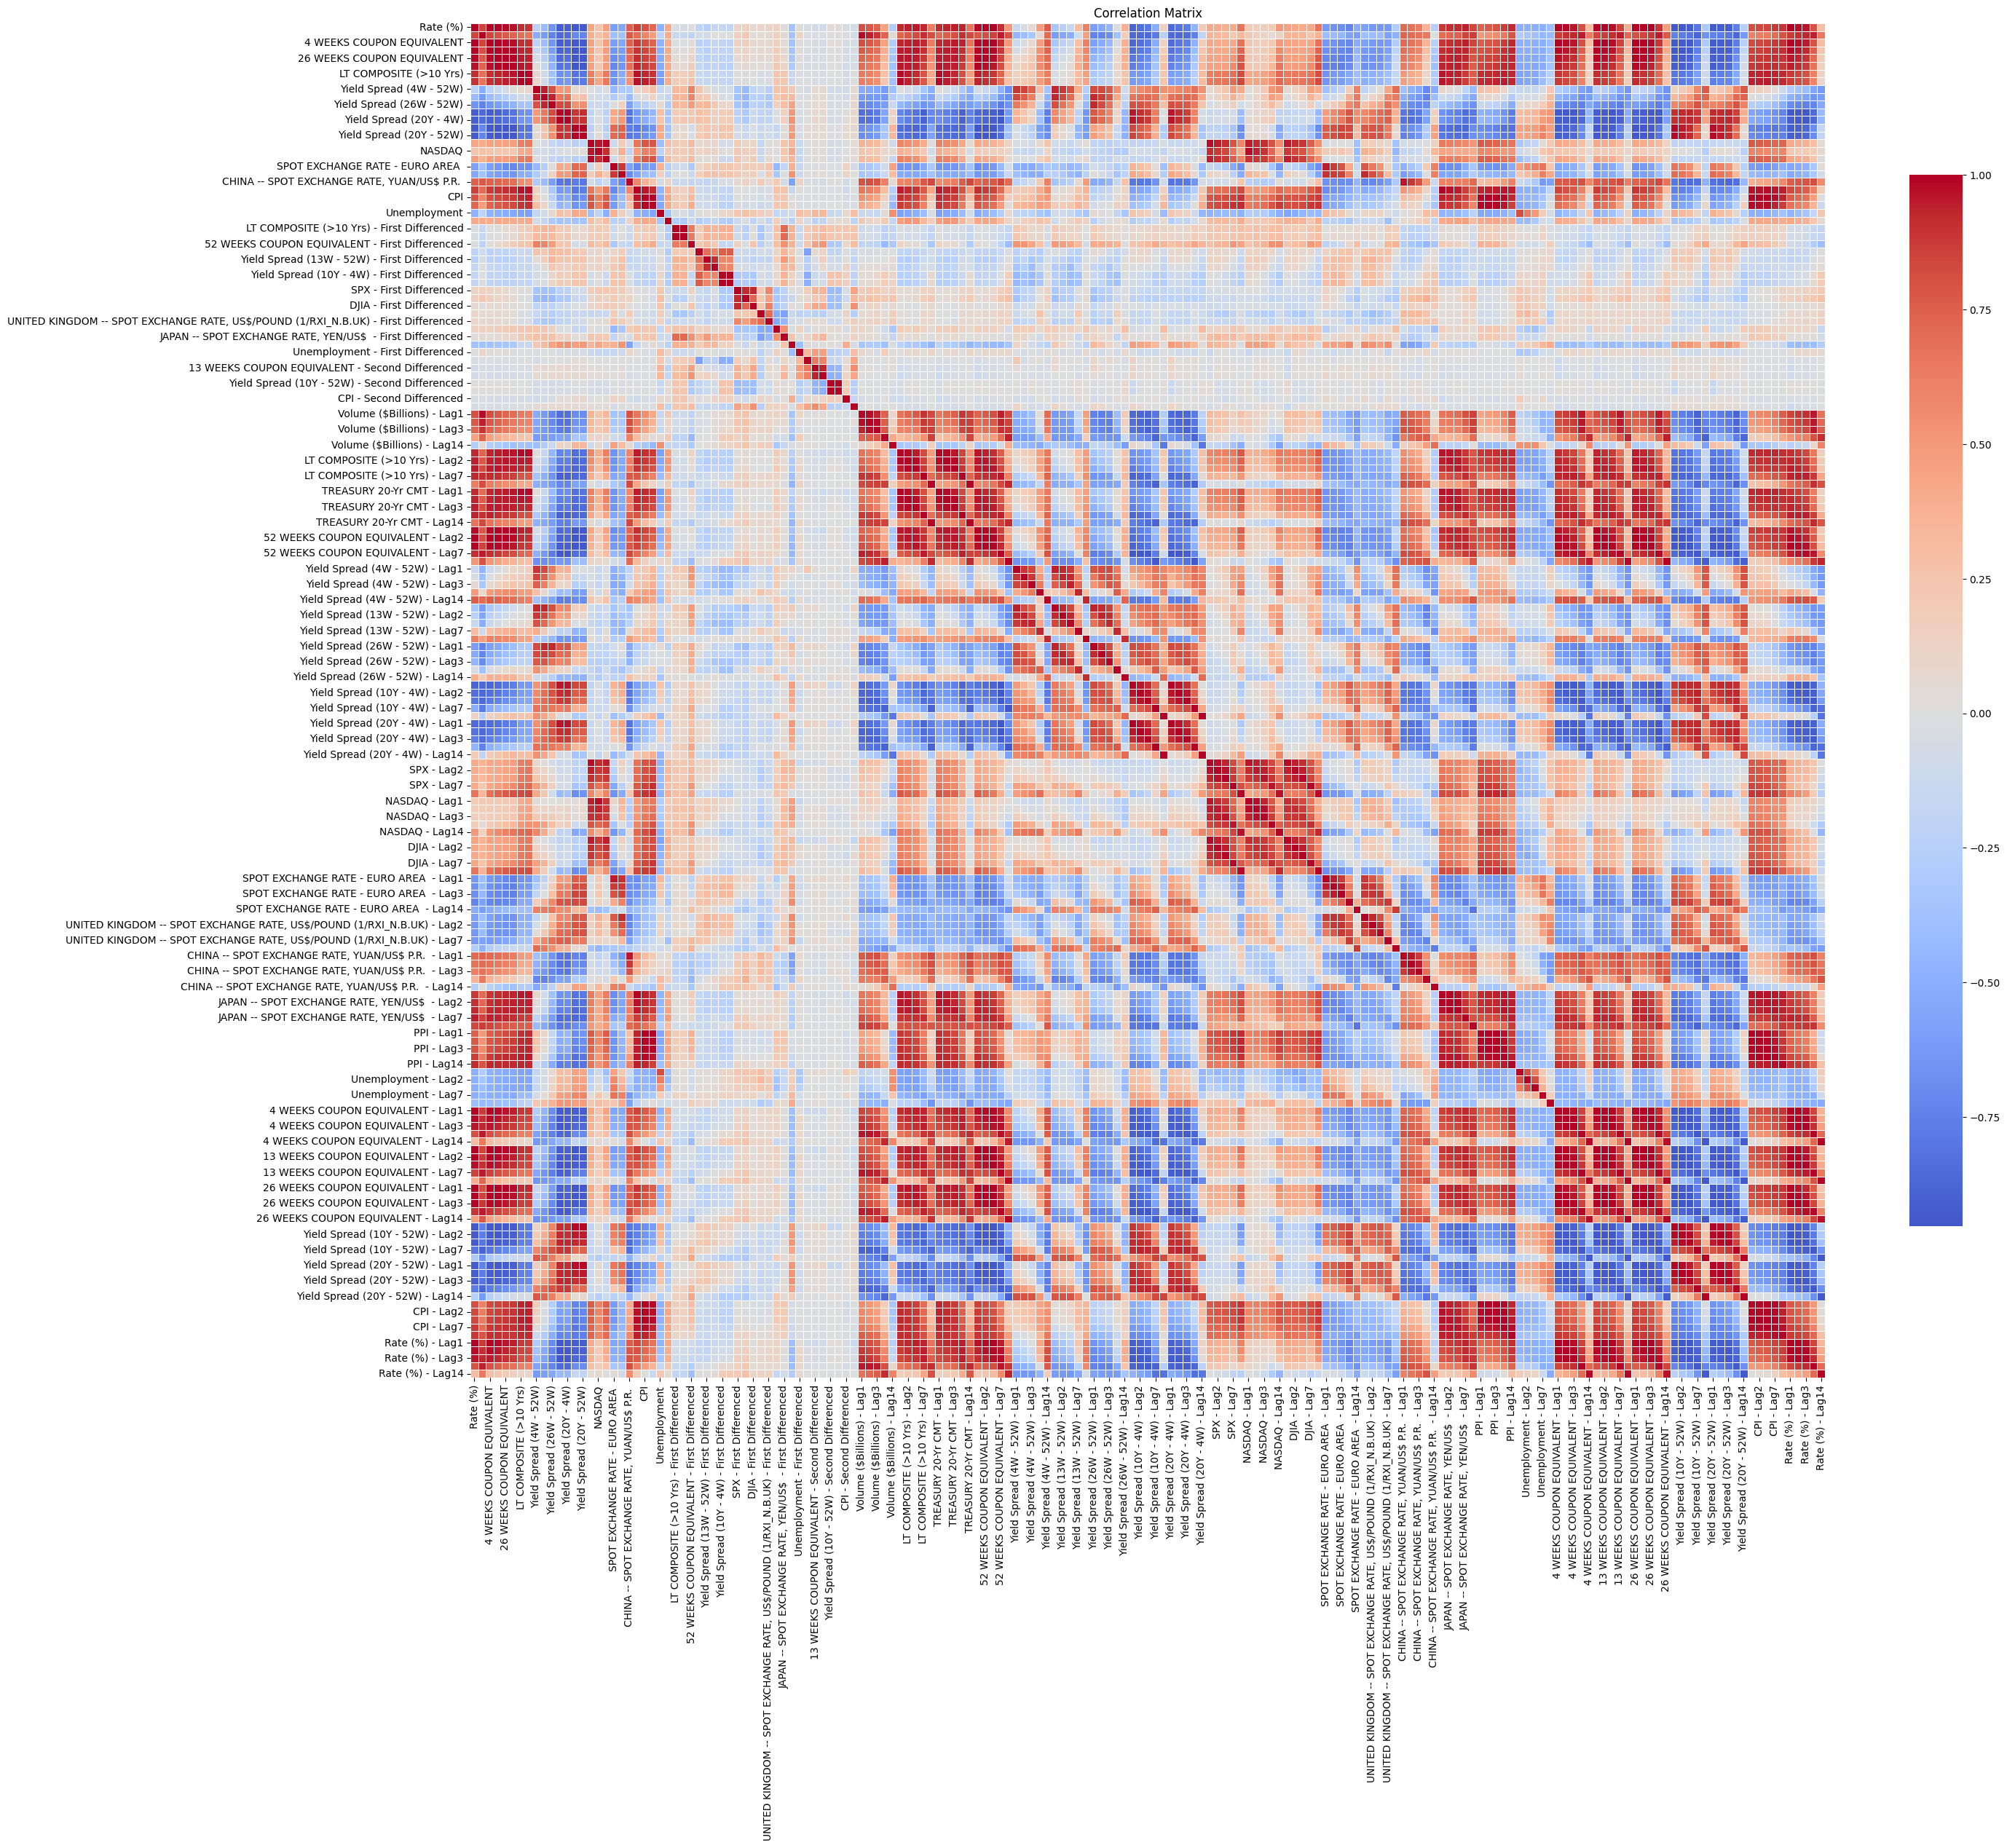

In [34]:
# Calculate the correlation matrix
correlation_matrix = df_prepared.corr()

# Plot the heatmap
plt.figure(figsize=(30, 25)) #14,12
sns.heatmap(correlation_matrix, annot=False, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .75})
plt.title('Correlation Matrix')
plt.show()

### ADDITIONALS

In [35]:
import pandas as pd
import numpy as np

# Assuming df is your DataFrame with over 130 factors
correlation_matrix = df_prepared.corr().abs()  # Use absolute values to consider both positive and negative correlations

# Print the correlation matrix if needed
# print(correlation_matrix)


In [36]:
# Create a mask to ignore the diagonal elements (self-correlations)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Apply the mask to the correlation matrix
correlation_matrix = correlation_matrix.mask(mask)

# Set a threshold for high correlations (e.g., 0.8)
high_correlation_threshold = 0.8

# Find pairs of features with correlation above the threshold
high_correlation_pairs = np.where(correlation_matrix > high_correlation_threshold)
high_correlation_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y])
                          for x, y in zip(*high_correlation_pairs) if x != y]

print("Highly correlated pairs of features:")
print(high_correlation_pairs)


Highly correlated pairs of features:
[('Volume ($Billions)', 'Rate (%)'), ('4 WEEKS COUPON EQUIVALENT', 'Rate (%)'), ('4 WEEKS COUPON EQUIVALENT', 'Volume ($Billions)'), ('13 WEEKS COUPON EQUIVALENT', 'Rate (%)'), ('13 WEEKS COUPON EQUIVALENT', 'Volume ($Billions)'), ('13 WEEKS COUPON EQUIVALENT', '4 WEEKS COUPON EQUIVALENT'), ('26 WEEKS COUPON EQUIVALENT', 'Rate (%)'), ('26 WEEKS COUPON EQUIVALENT', '4 WEEKS COUPON EQUIVALENT'), ('26 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT'), ('52 WEEKS COUPON EQUIVALENT', 'Rate (%)'), ('52 WEEKS COUPON EQUIVALENT', '4 WEEKS COUPON EQUIVALENT'), ('52 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT'), ('52 WEEKS COUPON EQUIVALENT', '26 WEEKS COUPON EQUIVALENT'), ('LT COMPOSITE (>10 Yrs)', 'Rate (%)'), ('LT COMPOSITE (>10 Yrs)', '4 WEEKS COUPON EQUIVALENT'), ('LT COMPOSITE (>10 Yrs)', '13 WEEKS COUPON EQUIVALENT'), ('LT COMPOSITE (>10 Yrs)', '26 WEEKS COUPON EQUIVALENT'), ('LT COMPOSITE (>10 Yrs)', '52 WEEKS COUPON EQUIVALENT'), ('TR

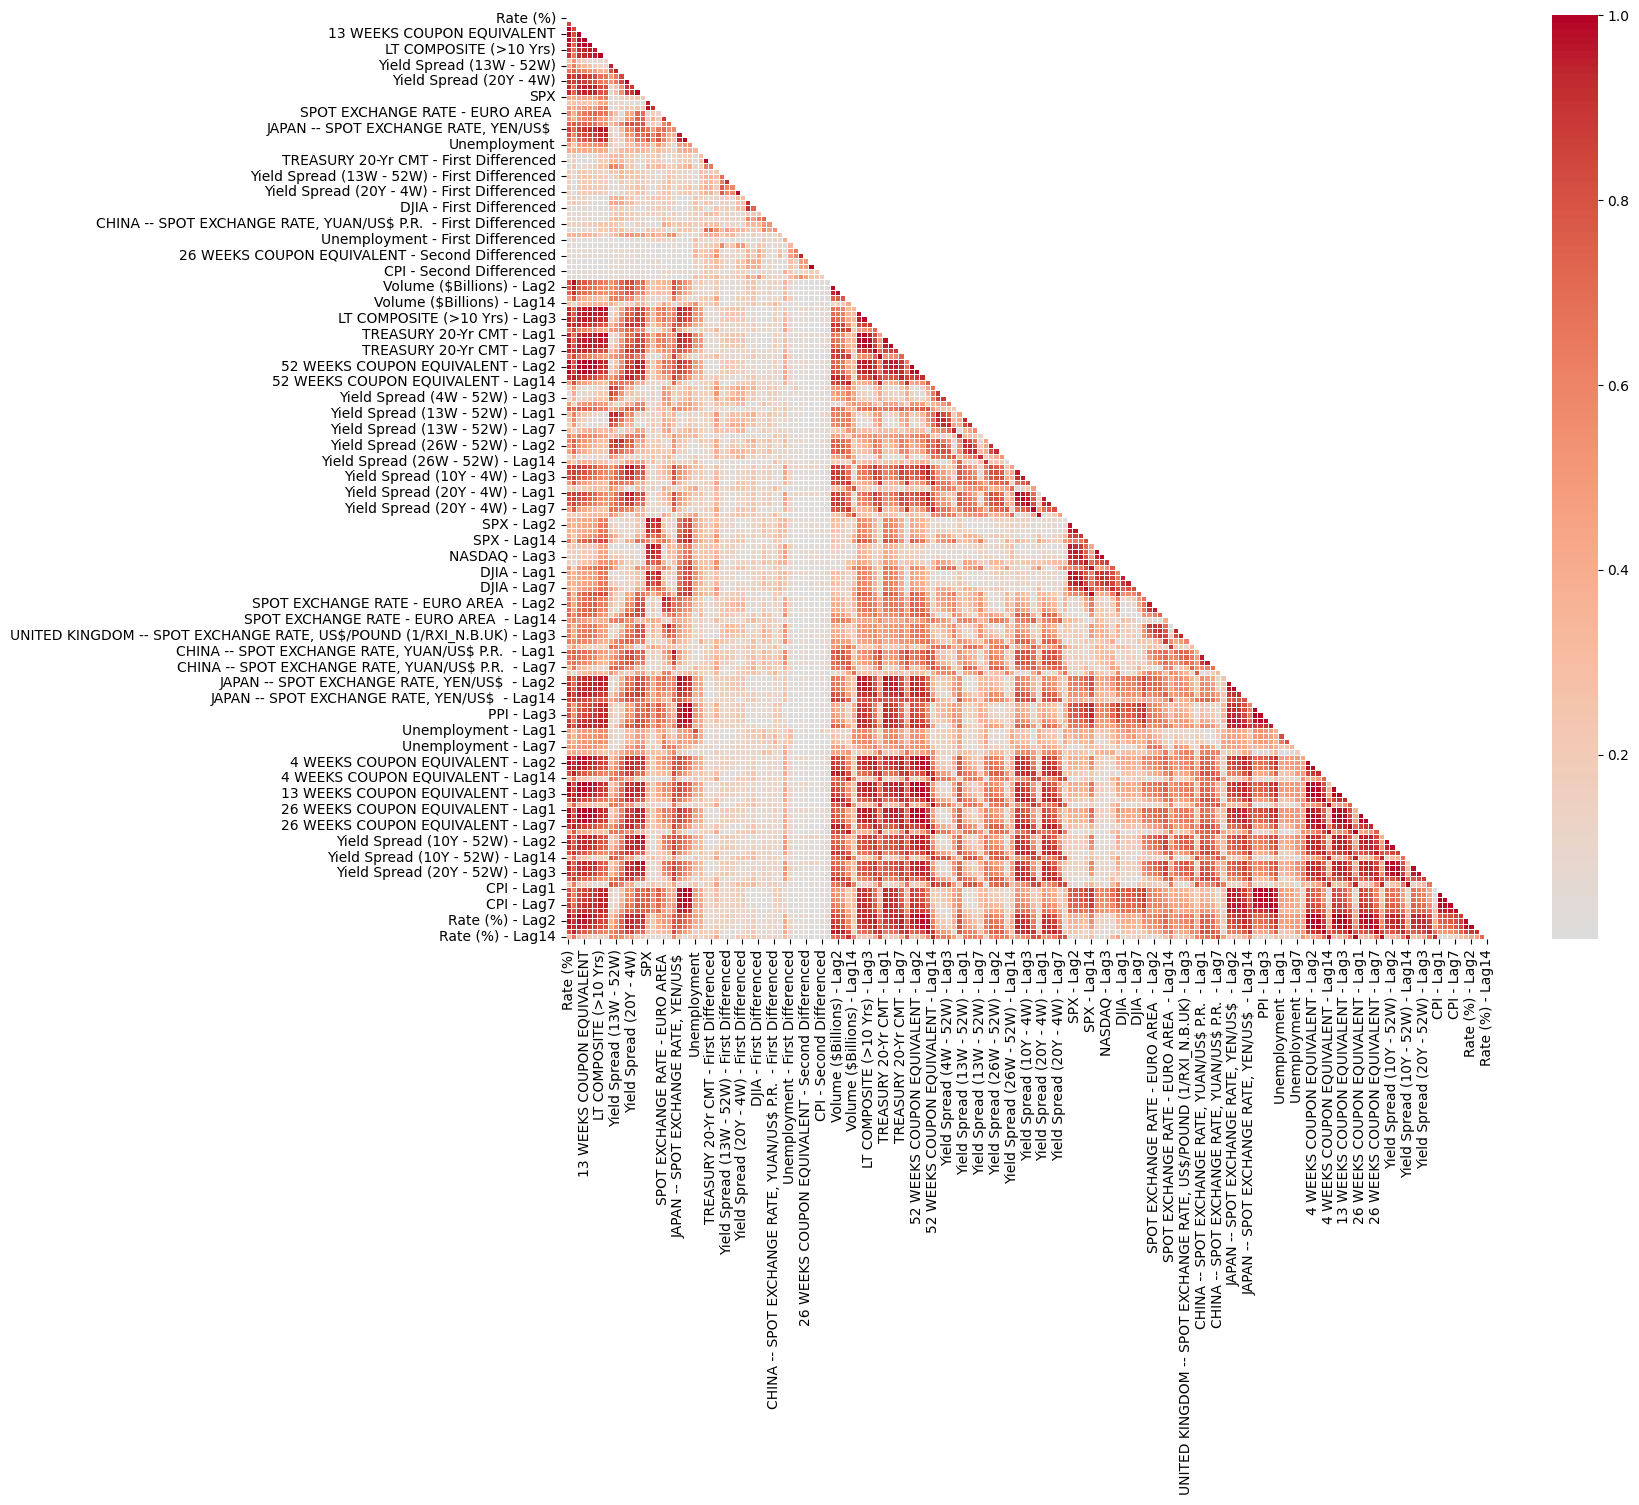

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the size of the heatmap
plt.figure(figsize=(16, 12))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5, annot=False, fmt='.2f')

plt.show()


In [38]:
vif_df = df_prepared.copy()
# Set to keep track of features to drop
features_to_drop = set()

for pair in high_correlation_pairs:
    feature1, feature2 = pair

    # Drop the second feature of the pair
    features_to_drop.add(feature1)

# Drop the features from the DataFrame
df_reduced = vif_df.drop(columns=features_to_drop)

print("Features dropped due to high correlation:")
print(features_to_drop)


Features dropped due to high correlation:
{'TREASURY 20-Yr CMT - Lag1', '13 WEEKS COUPON EQUIVALENT', 'SPX - Lag7', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$  - Lag1', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - Lag7', '4 WEEKS COUPON EQUIVALENT', 'Yield Spread (10Y - 4W) - Lag1', '4 WEEKS COUPON EQUIVALENT - Lag14', '52 WEEKS COUPON EQUIVALENT - Lag14', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ', 'PPI', 'Yield Spread (10Y - 52W) - Lag1', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - Lag1', 'Yield Spread (10Y - 52W) - Lag7', 'CPI - Lag1', 'Unemployment - Lag2', 'Yield Spread (26W - 52W) - Lag14', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$  - Lag3', 'PPI - Lag3', 'SPOT EXCHANGE RATE - EURO AREA  - Lag7', '26 WEEKS COUPON EQUIVALENT - Lag3', 'Yield Spread (10Y - 52W) - Lag3', 'Yield Spread (10Y - 4W) - Lag7', 'Rate (%) - Lag7', 'SPX - Lag14', 'Yield Spread (10Y - 4W)', 'NASDAQ - First Differenced', 'Yield Spread (20Y - 4W) - First Differenced', 'LT COMPOSITE (>10 Yrs)', 'Yield

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_reduced.values
vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif_df["Variable"] = df_reduced.columns

print("VIF values after handling multicollinearity:")
vif_df

VIF values after handling multicollinearity:


,VIF,Variable
0,102.973081,Rate (%)
1,31.664101,Yield Spread (4W - 52W)
2,265.812985,SPX
3,8079.379370,SPOT EXCHANGE RATE - EURO AREA
4,53.831038,Unemployment
5,3.487525,Volume ($Billions) - First Differenced
6,114.251465,LT COMPOSITE (>10 Yrs) - First Differenced
7,107.693781,52 WEEKS COUPON EQUIVALENT - First Differenced
8,168.513158,Yield Spread (4W - 52W) - First Differenced
9,15.652448,Yield Spread (13W - 52W) - First Differenced


### Drop Columns

In [40]:
vif_df['Variable'].to_list()

['Rate (%)',
 'Yield Spread (4W - 52W)',
 'SPX',
 'SPOT EXCHANGE RATE - EURO AREA ',
 'Unemployment',
 'Volume ($Billions) - First Differenced',
 'LT COMPOSITE (>10 Yrs) - First Differenced',
 '52 WEEKS COUPON EQUIVALENT - First Differenced',
 'Yield Spread (4W - 52W) - First Differenced',
 'Yield Spread (13W - 52W) - First Differenced',
 'Yield Spread (10Y - 4W) - First Differenced',
 'SPX - First Differenced',
 'SPOT EXCHANGE RATE - EURO AREA  - First Differenced',
 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - First Differenced',
 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - First Differenced',
 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$  - First Differenced',
 'PPI - First Differenced',
 'Unemployment - First Differenced',
 '4 WEEKS COUPON EQUIVALENT - Second Differenced',
 '13 WEEKS COUPON EQUIVALENT - Second Differenced',
 'Yield Spread (10Y - 52W) - Second Differenced',
 'CPI - Second Differenced',
 'Rate (%) - Second Differenced',
 'Volume ($Billions) - Lag7',


In [41]:
# columns_to_drop = ['Volume ($Billions) - First Differenced',  'NASDAQ - First Differenced',
#  'DJIA - First Differenced',  'SPOT EXCHANGE RATE - EURO AREA  - First Differenced',
#  'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - First Differenced',  'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - First Differenced',
#  'JAPAN -- SPOT EXCHANGE RATE, YEN/US$  - First Differenced',  '4 WEEKS COUPON EQUIVALENT - Second Differenced',
#  'CPI - Second Differenced',  'Rate (%) - Second Differenced',
#  'Yield Spread (26W - 52W) - Lag14',  'Rate (%) - Lag14'
#                    ] - THIS IS WRONG SHOULD BE THE INVERSE

columns_to_drop = ['Rate (%)',
 'Yield Spread (4W - 52W)',
 'SPX',
 'SPOT EXCHANGE RATE - EURO AREA ',
 'Unemployment',
 'LT COMPOSITE (>10 Yrs) - First Differenced',
 '52 WEEKS COUPON EQUIVALENT - First Differenced',
 'Yield Spread (4W - 52W) - First Differenced',
 'Yield Spread (13W - 52W) - First Differenced',
 'Yield Spread (10Y - 4W) - First Differenced',
 'SPX - First Differenced',
 'SPOT EXCHANGE RATE - EURO AREA  - First Differenced',
 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - First Differenced',
 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$  - First Differenced',
 'PPI - First Differenced',
 '4 WEEKS COUPON EQUIVALENT - Second Differenced',
 '13 WEEKS COUPON EQUIVALENT - Second Differenced',
 'Yield Spread (10Y - 52W) - Second Differenced',
 'Volume ($Billions) - Lag7',
 'Volume ($Billions) - Lag14',
 'Yield Spread (4W - 52W) - Lag7',
 'Yield Spread (4W - 52W) - Lag14',
 'Yield Spread (10Y - 4W) - Lag14',
 'SPOT EXCHANGE RATE - EURO AREA  - Lag14',
 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - Lag7',
 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - Lag14',
 'Unemployment - Lag7',
 'Unemployment - Lag14']

df_prepared_nona = df_reduced.drop(columns=columns_to_drop)
df_prepared_nona['Rate (%)'] = df_final2['Rate (%)']

# Train/Test

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible

                                      SARIMAX Results                                      
Dep. Variable:                            Rate (%)   No. Observations:                   43
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 6)   Log Likelihood                   1.169
Date:                             Wed, 07 Aug 2024   AIC                             21.661
Time:                                     22:23:29   BIC                             40.992
Sample:                                 06-30-2019   HQIC                            28.476
                                      - 12-31-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2316      0.314      0.738      0.460      -0.383       0.846
x2            -0.1187      

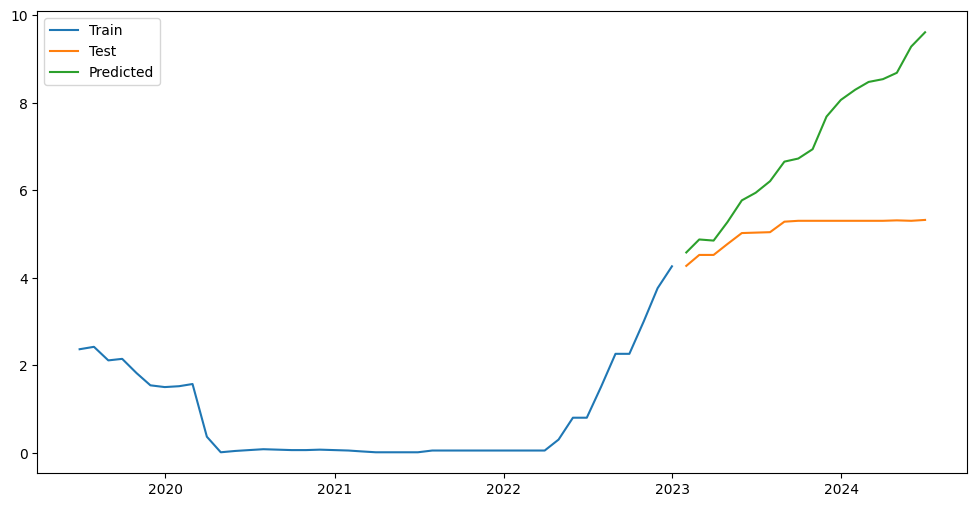

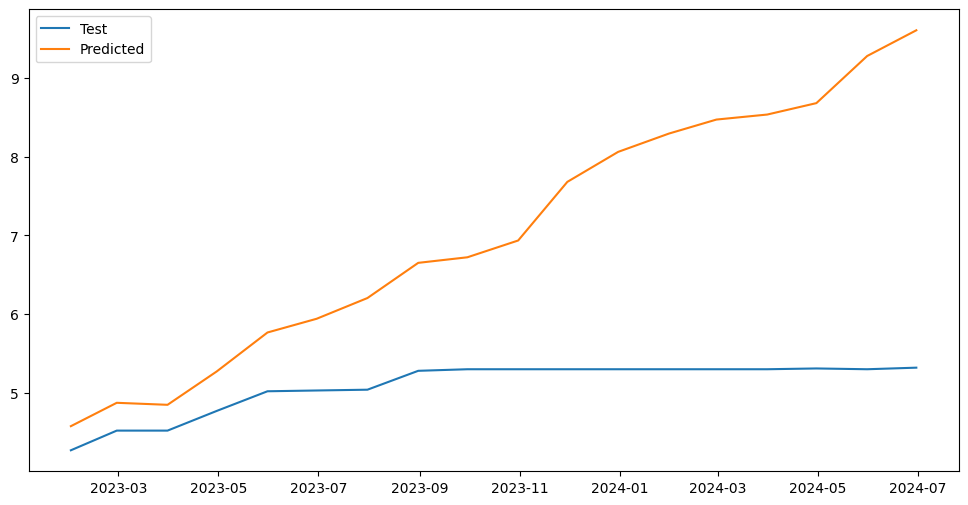

Mean Squared Error: 5.4641
Mean Absolute Error: 1.941
R2 Score: -50.101
Root Mean Squared Error: 2.3376


In [99]:
# Split into train and test

train = df_prepared_nona[:'2022-12-31']
test = df_prepared_nona['2023-01-01':]

# Split into X & y

# y_train = train['Rate (%) - Second Differenced']
# X_train = train.drop(columns=['Rate (%) - Second Differenced'])
# y_test = test['Rate (%) - Second Differenced']
# X_test = test.drop(columns=['Rate (%) - Second Differenced'])

y_train = train['Rate (%)']
X_train = train.drop(columns=['Rate (%)'])
y_test = test['Rate (%)']
X_test = test.drop(columns=['Rate (%)'])


# Scaling values

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# model definition

model = SARIMAX(y_train, exog= X_train_scaled, order= (2,0,2), seasonal_order= (1,1,1,6)) # order was (1,1,1) seasonal_order was (0,0,0,0)
# (p, d, q) = (1,1,2) so dependent is differenced 1 (d) time, dependent lag 1 (p), error lag 2 (q)
# (P, D, Q, s) = (2,1,1,6) seasonal differencing 1 (D) time on a period of 6 (s), seasonal lag 2 (P), moving average 1 (Q)

model_fit = model.fit(disp=False)
print(model_fit.summary())

# Prediction and plotting

# Predict using the test set
y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test_scaled)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

print("\n\n")

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rsquare = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print(f'Mean Squared Error: {round(mse,4)}')
print(f'Mean Absolute Error: {round(mae,4)}')
print(f'R2 Score: {round(rsquare,4)}')
print(f'Root Mean Squared Error: {round(rmse,4)}')